Detecting the arrival of P waves and S waves

No S-wave detected. Only marking P-wave peak.
P Arrival: 756.71 s


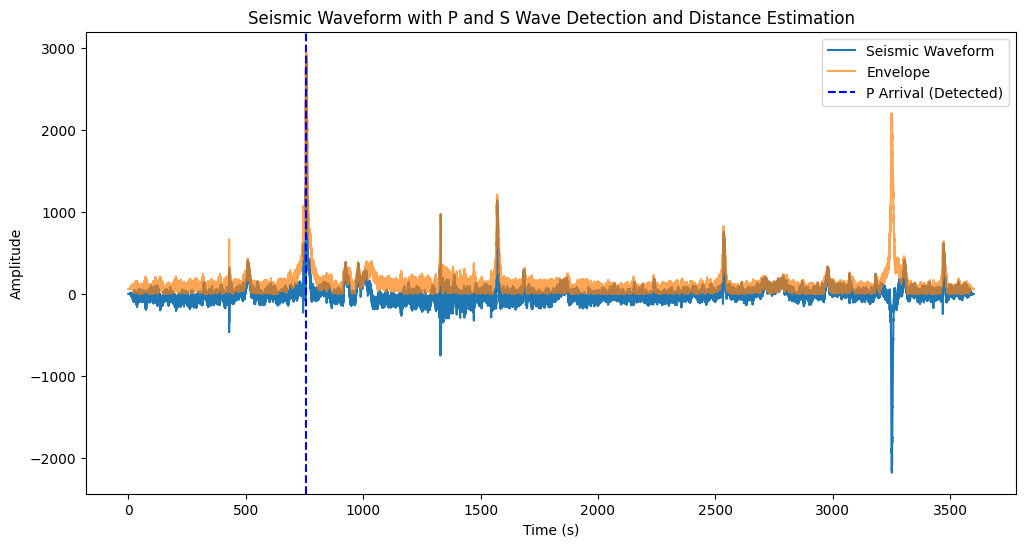

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from obspy.signal.cross_correlation import correlate, xcorr_max
from scipy.signal import hilbert

# Defining Mars-specific seismic model (simplified 1D model)
MARS_MODEL = {
    "crust": {"thickness": 50, "vp": 6.0, "vs": 3.5},  # km, km/s
    "mantle": {"thickness": 1500, "vp": 8.0, "vs": 4.5},
    "core": {"radius": 1800, "vp": 13.0, "vs": 0.0},  # No S waves in liquid core
}

def compute_travel_time(distance, layer):
    vp = layer["vp"]
    vs = layer["vs"]
    return distance / vp, (distance / vs if vs > 0 else np.inf)

def calculate_travel_times(distance):
    travel_times = {"P": 0, "S": 0}
    remaining_distance = distance
    
    for layer_name, layer in MARS_MODEL.items():
        thickness = layer.get("thickness", np.inf)
        layer_distance = min(remaining_distance, thickness)
        
        p_time, s_time = compute_travel_time(layer_distance, layer)
        travel_times["P"] += p_time
        travel_times["S"] += s_time
        
        remaining_distance -= layer_distance
        if remaining_distance <= 0:
            break
    
    return travel_times

def envelope_method(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

def estimate_distance(delta_t, vp, vs):
    return delta_t * (vp * vs) / (vp - vs)

def process_mseed_file(file_path):
    st = read(file_path)
    tr = st[0]  # Assume single trace for simplicity
    
    envelope = envelope_method(tr.data)
    
    sampling_rate = tr.stats.sampling_rate
    times = np.linspace(0, tr.stats.npts / sampling_rate, tr.stats.npts)
    
    p_peak_index = np.argmax(envelope[:int(0.5 * len(envelope))])  # P wave in first half
    s_peak_index = np.argmax(envelope[p_peak_index + 1:]) + p_peak_index + 1  # S wave after P wave
    
    p_arrival_time = times[p_peak_index]
    s_arrival_time = times[s_peak_index]
    delta_t = s_arrival_time - p_arrival_time
    
    vp, vs = MARS_MODEL["crust"]["vp"], MARS_MODEL["crust"]["vs"]
    
    if delta_t < 240:
        print("No S-wave detected. Only marking P-wave peak.")
        s_arrival_time = None
    else:
        distance = estimate_distance(delta_t, vp, vs)
        print(f"Estimated Distance: {distance:.2f} km")
    
    print(f"P Arrival: {p_arrival_time:.2f} s")
    if s_arrival_time:
        print(f"S Arrival: {s_arrival_time:.2f} s")
    
    plt.figure(figsize=(12, 6))
    plt.plot(times, tr.data, label="Seismic Waveform")
    plt.plot(times, envelope, label="Envelope", alpha=0.7)
    
    plt.axvline(p_arrival_time, color='blue', linestyle='--', label='P Arrival (Detected)')
    if s_arrival_time:
        plt.axvline(s_arrival_time, color='green', linestyle='--', label='S Arrival (Detected)')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Seismic Waveform with P and S Wave Detection and Distance Estimation")
    plt.legend()
    plt.show()

def main():
    file_path = "mseed files/XB.ELYSE.02.BHV.2019-07-26HR12_evid0033.mseed" 
    process_mseed_file(file_path)

if __name__ == "__main__":
    main()

Extracting Properties

P Wave Properties: {'wave_type': 'P', 'amplitude': 1570.604736328125, 'peak_to_peak': 2805.0841064453125, 'mean': 86.48362731933594, 'variance': 811433.84259615, 'duration': 0.5, 'energy': 8189132.603904598, 'frequency': 4.0, 'wavelength': 1.25, 'velocity': 5.0, 'polarization': 'longitudinal', 'direction': 'source-receiver', 'magnitude': 4.608825269037874, 'stress_drop': 25129.67578125}
S Wave Properties: {'wave_type': 'S', 'amplitude': 1667.312255859375, 'peak_to_peak': 2845.168212890625, 'mean': 155.9491760253906, 'variance': 972860.320459368, 'duration': 0.5, 'energy': 9971804.659623664, 'frequency': 2.0, 'wavelength': 1.5, 'velocity': 3.0, 'polarization': 'horizontal', 'direction': 'source-receiver', 'magnitude': 4.665849174935393, 'stress_drop': 6669.2490234375}


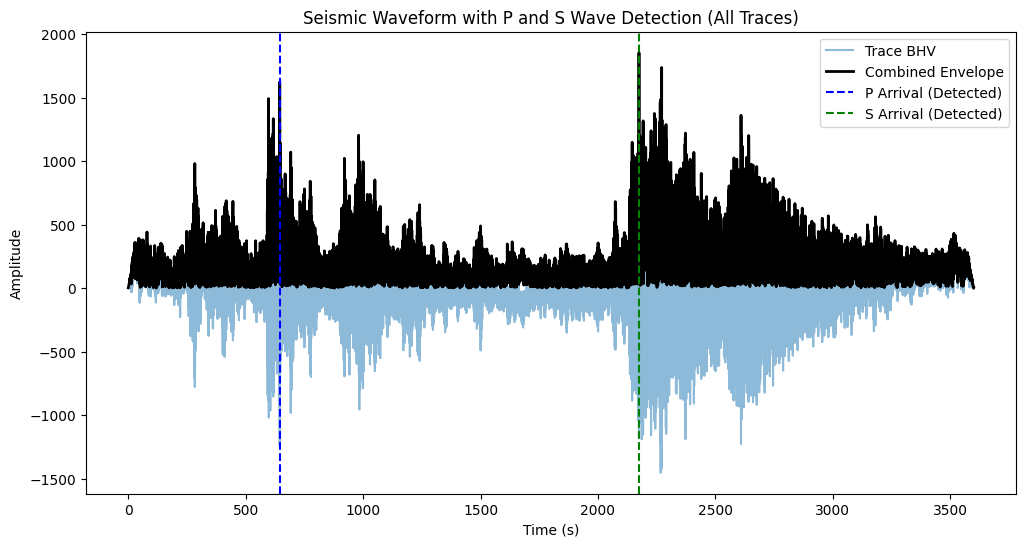

Wave properties saved to wave_properties.csv


In [54]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from obspy import read
from scipy.signal import hilbert
from scipy.fftpack import fft

# Enhanced Mars-specific seismic model with layered structure
MARS_MODEL = {
    "upper_crust": {"thickness": 20, "vp": 5.0, "vs": 3.0},  
    "lower_crust": {"thickness": 30, "vp": 6.5, "vs": 3.8},  
    "upper_mantle": {"thickness": 800, "vp": 8.0, "vs": 4.5},  
    "lower_mantle": {"thickness": 700, "vp": 9.5, "vs": 5.0},  
    "outer_core": {"radius": 1800, "vp": 13.0, "vs": 0.0}, 
    "inner_core": {"radius": 1300, "vp": 11.0, "vs": 0.0},  
}

def envelope_method(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

def calculate_magnitude(energy):
    # Simplified relation
    return np.log10(energy) / 1.5

def calculate_stress_drop(amplitude, dominant_frequency):
    # Simplified relation
    return amplitude * dominant_frequency ** 2

def extract_wave_properties(signal, sampling_rate, start_index, end_index, wave_type="P"):
    wave_segment = signal[start_index:end_index]

    # Time array for the wave segment
    times = np.linspace(0, (end_index - start_index) / sampling_rate, end_index - start_index)

    amplitude = np.max(np.abs(wave_segment))

    peak_to_peak = np.ptp(wave_segment)

    mean_value = np.mean(wave_segment)

    variance = np.var(wave_segment)

    duration = (end_index - start_index) / sampling_rate

    energy = np.sum(wave_segment ** 2)

    # Frequency Content: Dominant frequency using Fourier Transform
    n = len(wave_segment)
    fft_values = np.abs(fft(wave_segment))
    frequencies = np.fft.fftfreq(n, d=1 / sampling_rate)
    positive_frequencies = frequencies[:n // 2]
    positive_fft_values = fft_values[:n // 2]
    dominant_frequency = positive_frequencies[np.argmax(positive_fft_values)]

    # Wavelength: Using wave velocity and dominant frequency
    velocity = MARS_MODEL["upper_crust"]["vp"] if wave_type == "P" else MARS_MODEL["upper_crust"]["vs"]
    wavelength = velocity / dominant_frequency if dominant_frequency > 0 else np.inf

    polarization = "horizontal" if wave_type == "S" else "longitudinal"

    direction = "source-receiver"

    magnitude = calculate_magnitude(energy)
    stress_drop = calculate_stress_drop(amplitude, dominant_frequency)

    return {
        "wave_type": wave_type,
        "amplitude": amplitude,
        "peak_to_peak": peak_to_peak,
        "mean": mean_value,
        "variance": variance,
        "duration": duration,
        "energy": energy,
        "frequency": dominant_frequency,
        "wavelength": wavelength,
        "velocity": velocity,
        "polarization": polarization,
        "direction": direction,
        "magnitude": magnitude,
        "stress_drop": stress_drop,
    }

def process_mseed_file(file_path, output_csv):
    st = read(file_path)
    sampling_rate = st[0].stats.sampling_rate
    times = np.linspace(0, st[0].stats.npts / sampling_rate, st[0].stats.npts)

    # Initialize arrays for combined analysis
    combined_envelope = np.zeros(len(times))

    for tr in st:  # Loop over all traces
        envelope = envelope_method(tr.data)
        combined_envelope += envelope  # Combine envelopes from all traces

    # Normalize the combined envelope
    combined_envelope /= len(st)

    # Detect P and S wave arrivals using envelope peaks
    p_peak_index = np.argmax(combined_envelope[:int(0.5 * len(combined_envelope))])  # P wave in first half
    s_peak_index = np.argmax(combined_envelope[p_peak_index + 1:]) + p_peak_index + 1  # S wave after P wave

    # Define extraction windows
    window_length = int(0.5 * sampling_rate)  # 0.5 seconds window
    p_start = max(0, p_peak_index - window_length // 2)
    p_end = min(len(times), p_peak_index + window_length // 2)
    s_start = max(0, s_peak_index - window_length // 2)
    s_end = min(len(times), s_peak_index + window_length // 2)

    # Extract properties for P and S waves
    p_wave_properties = extract_wave_properties(st[0].data, sampling_rate, p_start, p_end, wave_type="P")
    s_wave_properties = extract_wave_properties(st[0].data, sampling_rate, s_start, s_end, wave_type="S")

    # Write properties to CSV
    with open(output_csv, mode='w', newline='') as csvfile:
        fieldnames = ["wave_type", "amplitude", "peak_to_peak", "mean", "variance", "duration", "energy", "frequency", "wavelength", "velocity", "polarization", "direction", "magnitude", "stress_drop"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        writer.writerow(p_wave_properties)
        writer.writerow(s_wave_properties)

    print(f"P Wave Properties: {p_wave_properties}")
    print(f"S Wave Properties: {s_wave_properties}")

    # Plot waveform and arrivals
    plt.figure(figsize=(12, 6))
    for tr in st:
        plt.plot(times, tr.data, alpha=0.5, label=f"Trace {tr.stats.channel}")
    plt.plot(times, combined_envelope, label="Combined Envelope", color='black', linewidth=2)

    # Mark P and S wave arrivals
    plt.axvline(times[p_peak_index], color='blue', linestyle='--', label='P Arrival (Detected)')
    plt.axvline(times[s_peak_index], color='green', linestyle='--', label='S Arrival (Detected)')

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Seismic Waveform with P and S Wave Detection (All Traces)")
    plt.legend()
    plt.show()

def main():
    file_path = "XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.mseed"  
    output_csv = "wave_properties.csv" 

    process_mseed_file(file_path, output_csv)
    print(f"Wave properties saved to {output_csv}")

if __name__ == "__main__":
    main()


Generating Synthetic Waveforms

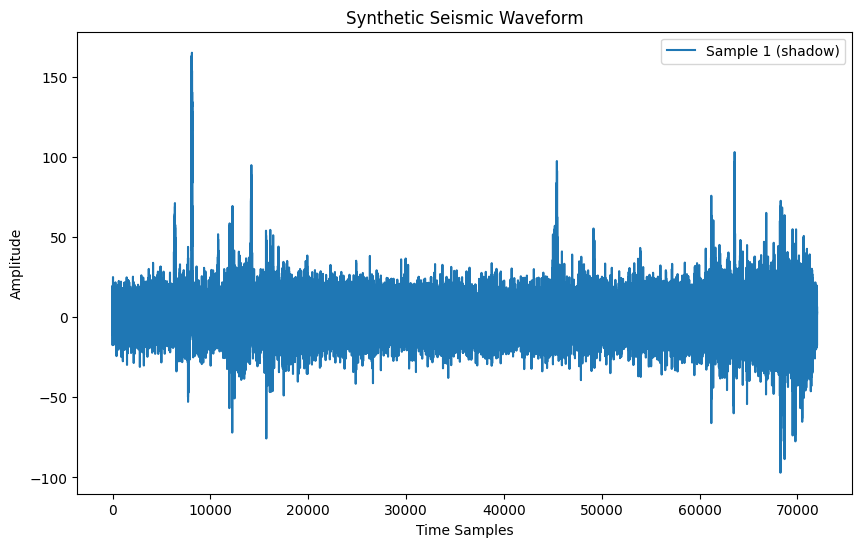

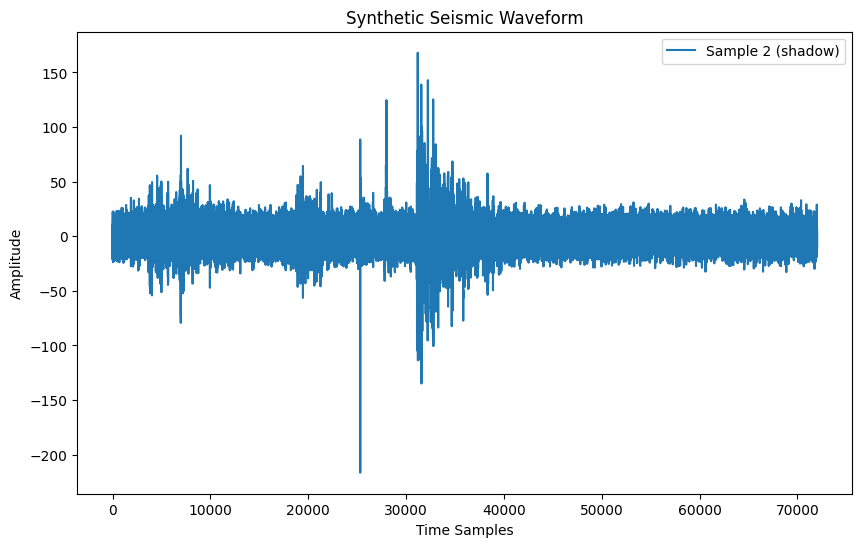

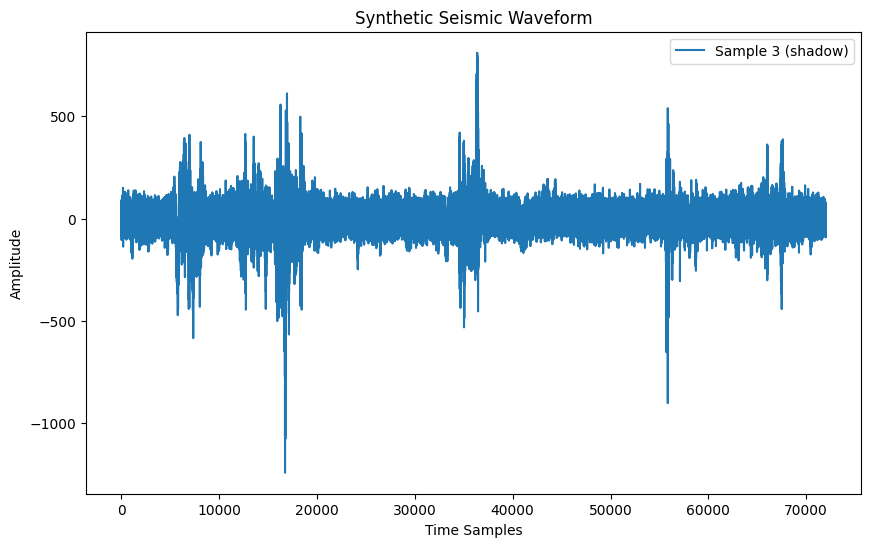

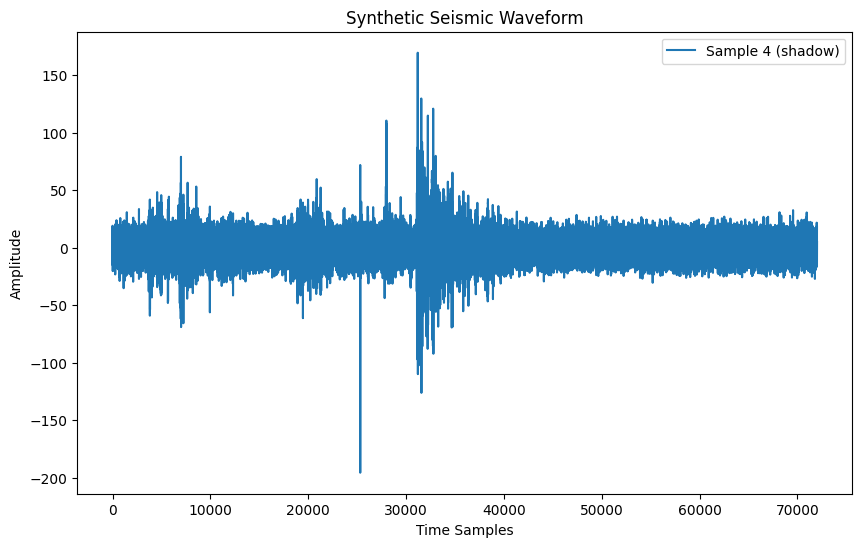

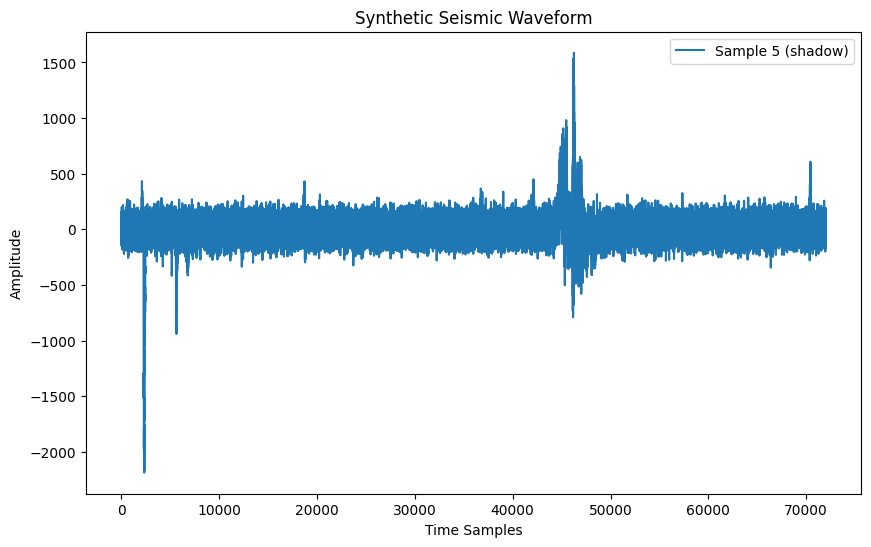

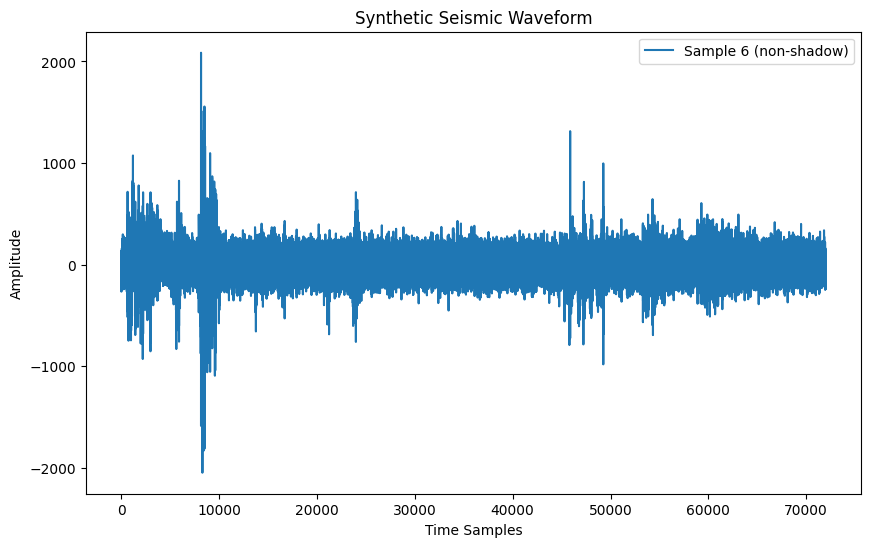

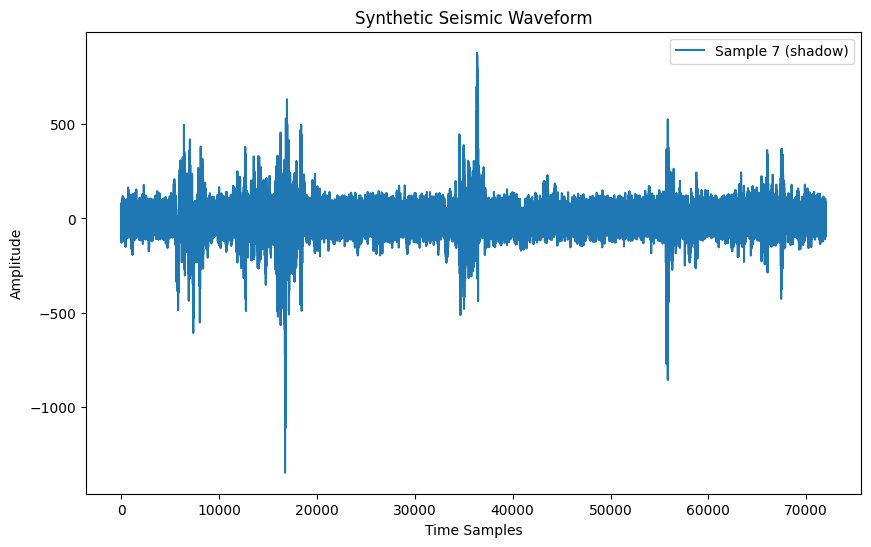

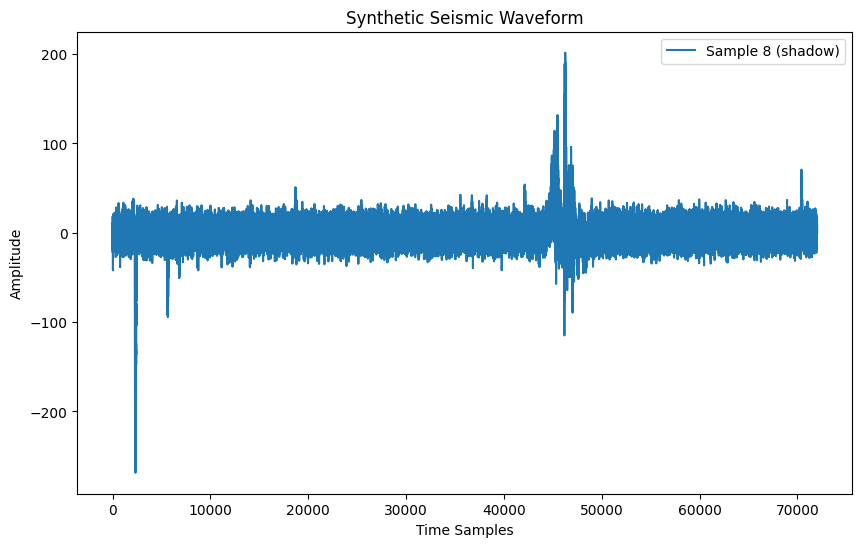

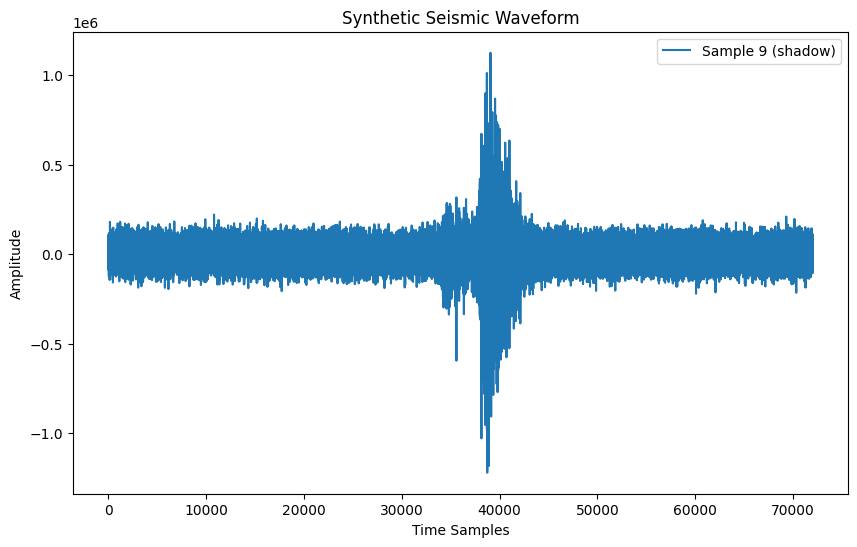

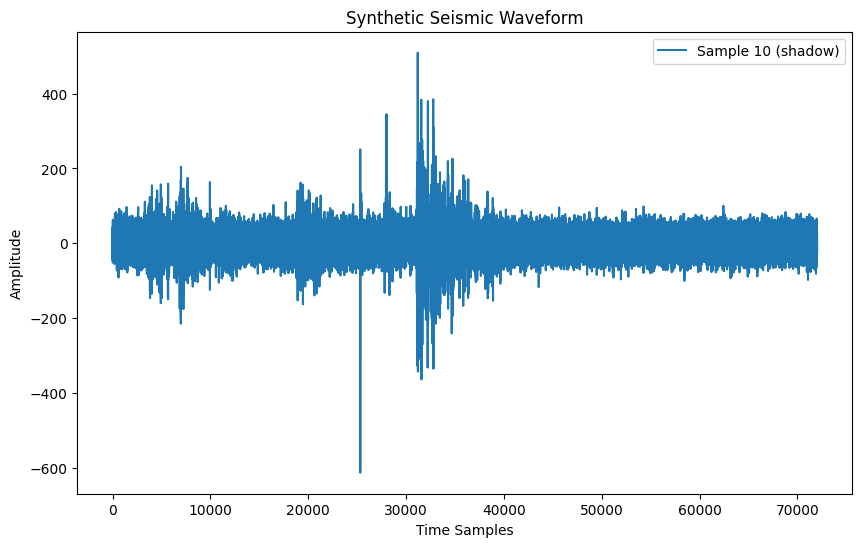

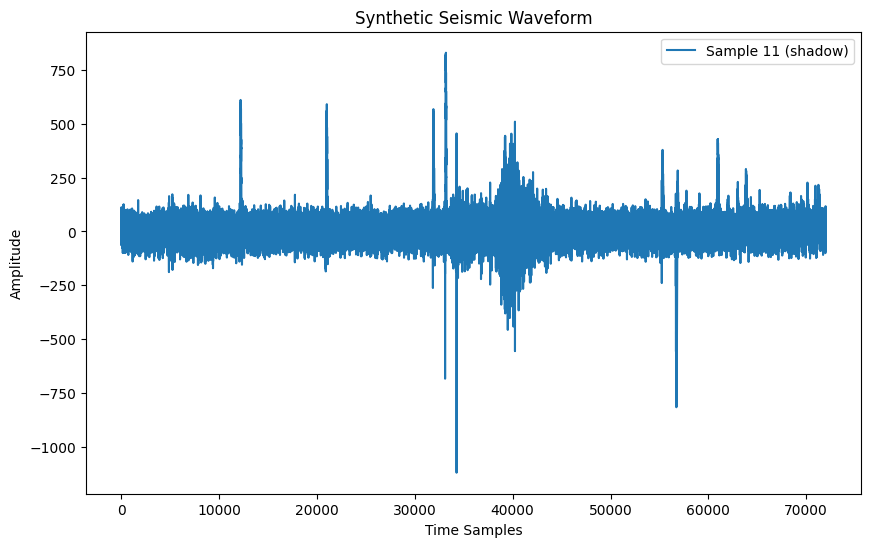

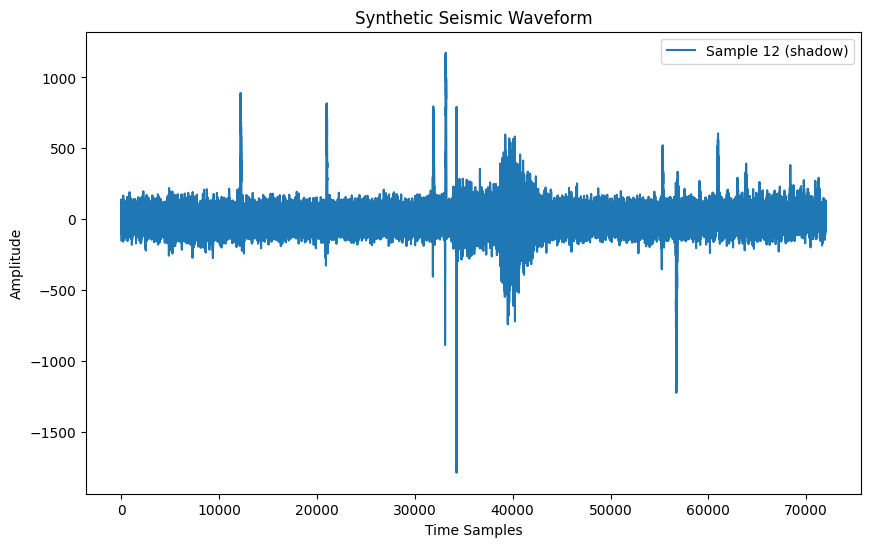

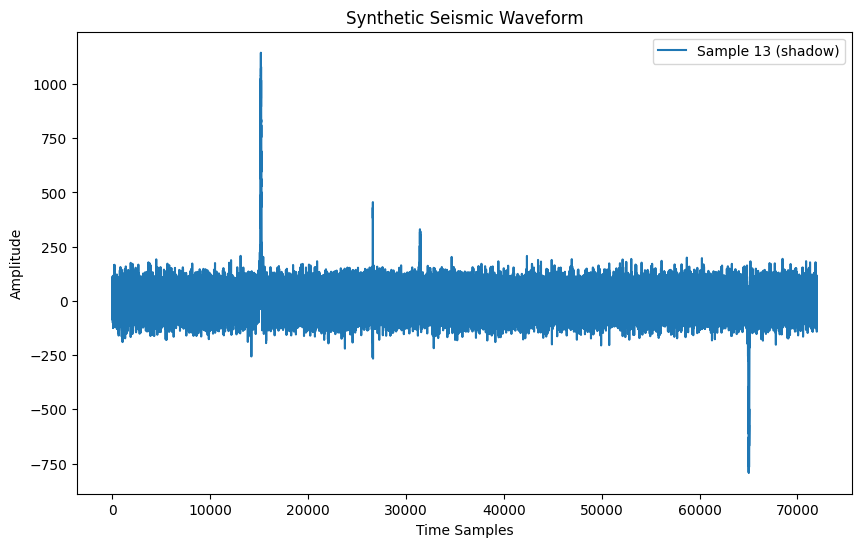

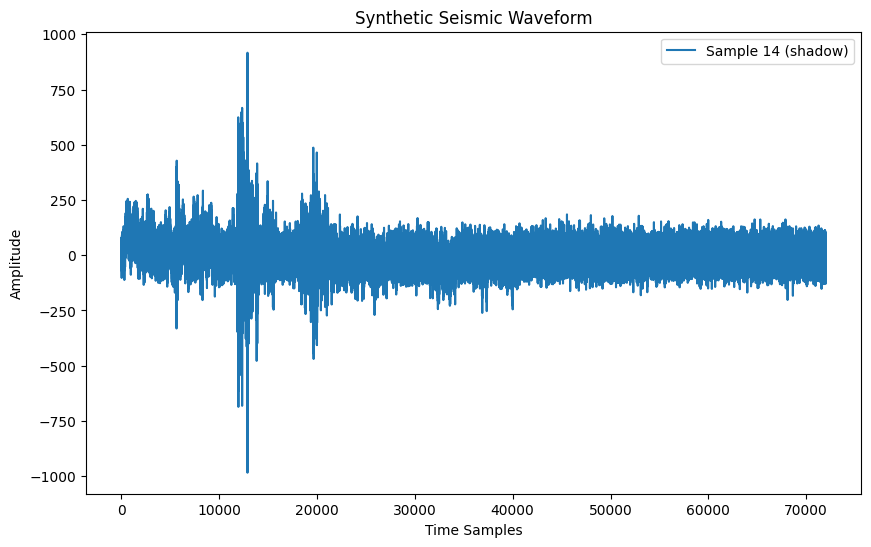

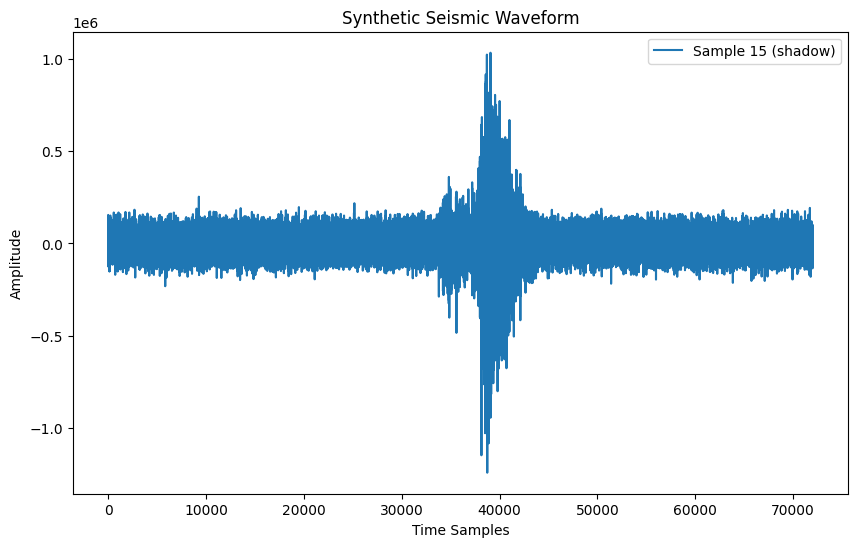

Synthetic dataset saved to synthetic_waveform_dataset.csv


In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from obspy import read, Trace, Stream
from scipy.signal import hilbert
from scipy.fftpack import fft
import random
import pywt

# Enhanced Mars-specific seismic model with layered structure
MARS_MODEL = {
    "upper_crust": {"thickness": 20, "vp": 5.0, "vs": 3.0},
    "lower_crust": {"thickness": 30, "vp": 6.5, "vs": 3.8},
    "upper_mantle": {"thickness": 800, "vp": 8.0, "vs": 4.5},
    "lower_mantle": {"thickness": 700, "vp": 9.5, "vs": 5.0},
    "outer_core": {"radius": 1800, "vp": 13.0, "vs": 0.0},
    "inner_core": {"radius": 1300, "vp": 11.0, "vs": 0.0},
}

def envelope_method(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

def extract_wavelet(signal, start_index, end_index):
    return signal[start_index:end_index]

def shift_wavelet(wavelet, shift_samples):
    shifted_wavelet = np.roll(wavelet, shift_samples)
    if shift_samples > 0:
        shifted_wavelet[:shift_samples] = 0
    else:
        shifted_wavelet[shift_samples:] = 0
    return shifted_wavelet

def add_gaussian_noise(signal, std_dev=0.02):
    noise = np.random.normal(0, std_dev * np.max(signal), size=len(signal))
    return signal + noise

def wavelet_denoise(signal, wavelet='db8', level=6, threshold=0.2):
    """Apply wavelet denoising to the signal using soft thresholding."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs_thresholded = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

def generate_synthetic_waveforms(signal, sampling_rate, p_wavelet, s_wavelet, num_samples=100):
    synthetic_data = []
    waveform_length = len(signal)
    
    for idx in range(num_samples):
        is_shadow = random.choice([True, False]) if s_wavelet is not None else True
        synthetic_waveform = np.zeros(waveform_length)

        if is_shadow:
            p_start_index = int(random.uniform(0.1, 0.4) * sampling_rate)
            end_index = min(p_start_index + len(p_wavelet), waveform_length)
            synthetic_waveform[p_start_index:end_index] += p_wavelet[:end_index - p_start_index] * random.uniform(0.1, 1.2)
        else:
            p_start_index = int(random.uniform(0.1, 0.2) * sampling_rate)
            shifted_p_wavelet = shift_wavelet(p_wavelet, random.randint(-50, 50))
            s_start_index = p_start_index + len(shifted_p_wavelet) + random.randint(int(0.1 * sampling_rate), int(0.5 * sampling_rate))
            p_end_index = min(p_start_index + len(shifted_p_wavelet), waveform_length)
            s_end_index = min(s_start_index + len(s_wavelet), waveform_length)
            shifted_s_wavelet = shift_wavelet(s_wavelet, random.randint(-50, 50))
            synthetic_waveform[p_start_index:p_end_index] = shifted_p_wavelet[:p_end_index - p_start_index] * random.uniform(0.5, 1.0)
            if s_start_index < waveform_length:
                synthetic_waveform[s_start_index:s_end_index] = shifted_s_wavelet[:s_end_index - s_start_index] * random.uniform(0.005, 1.0)
        
        synthetic_waveform = add_gaussian_noise(synthetic_waveform, std_dev=0.05)
        synthetic_data.append({
            "waveform": synthetic_waveform,
            "label": "shadow" if is_shadow else "non-shadow",
            "sampling_rate": sampling_rate,
            "index": idx
        })
    
    return synthetic_data
def save_waveforms_as_mseed(waveforms, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for sample in waveforms:
        trace = Trace()
        trace.data = sample["waveform"].astype(np.float32)
        trace.stats.sampling_rate = sample["sampling_rate"]
        trace.stats.station = "SYN"
        trace.stats.network = "XX"
        trace.stats.channel = "BHZ"
        trace.stats.starttime = 0
        
        stream = Stream(traces=[trace])
        filename = f"{output_folder}/synthetic_{sample['index']}_{sample['label']}.mseed"
        stream.write(filename, format="MSEED")


def visualize_waveforms(waveforms, num_samples=5):
    for i, sample in enumerate(random.sample(waveforms, min(num_samples, len(waveforms)))):
        plt.figure(figsize=(10, 6))
        plt.plot(sample["waveform"], label=f"Sample {i+1} ({sample['label']})")
        plt.title("Synthetic Seismic Waveform")
        plt.xlabel("Time Samples")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

def process_and_generate_dataset(folder_path, output_csv, output_mseed_folder, num_samples=100):
    synthetic_data = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mseed"):
            file_path = os.path.join(folder_path, file_name)
            st = read(file_path)
            sampling_rate = st[0].stats.sampling_rate
            times = np.linspace(0, st[0].stats.npts / sampling_rate, st[0].stats.npts)
            combined_envelope = np.zeros(len(times))
            
            # Denoise the original signal using wavelet denoising
            denoised_data = []
            for tr in st:
                denoised_signal = wavelet_denoise(tr.data)
                denoised_data.append(denoised_signal)
            st[0].data = np.mean(denoised_data, axis=0)
            
            # Proceed with envelope extraction and peak detection on the denoised signal
            combined_envelope = envelope_method(st[0].data)
            
            p_peak_index = np.argmax(combined_envelope[:int(0.5 * len(combined_envelope))])
            s_peak_index = np.argmax(combined_envelope[p_peak_index + 1:]) + p_peak_index + 1
            
            p_time = p_peak_index / sampling_rate
            s_time = s_peak_index / sampling_rate
            
            if (s_time - p_time) < 240:
                s_peak_index = None
                s_wavelet = None
            else:
                s_wavelet = extract_wavelet(st[0].data, s_peak_index-1000, len(st[0].data))
            
            p_wavelet = extract_wavelet(st[0].data, 0, s_peak_index-3000 if s_peak_index else len(st[0].data))
            
            synthetic_waveforms = generate_synthetic_waveforms(st[0].data, sampling_rate, p_wavelet, s_wavelet, num_samples=num_samples)
            synthetic_data.extend(synthetic_waveforms)
    
    visualize_waveforms(synthetic_data, num_samples=15)
    save_waveforms_as_mseed(synthetic_data, output_mseed_folder)
    
    with open(output_csv, mode='w', newline='') as csvfile:
        fieldnames = ["waveform", "label"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for sample in synthetic_data:
            writer.writerow({
                "waveform": sample["waveform"].tolist(),
                "label": sample["label"],
            })
    
    print(f"Synthetic dataset saved to {output_csv}")

def main():
    folder_path = "mseed files"
    output_csv = "synthetic_waveform_dataset.csv"
    output_mseed_folder = "synthetic_mseed"
    process_and_generate_dataset(folder_path, output_csv, output_mseed_folder, num_samples=200)

if __name__ == "__main__":
    main()

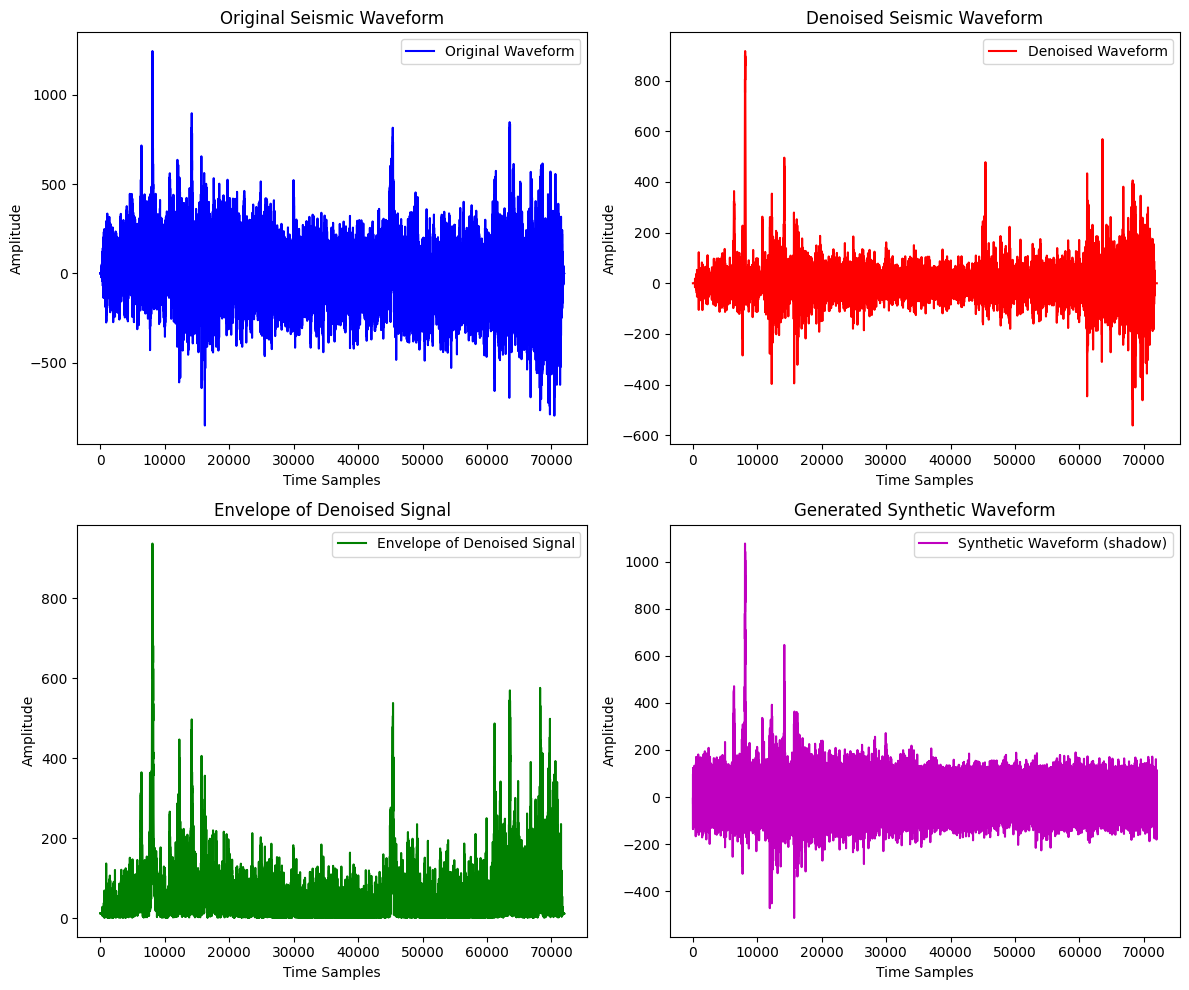


Dataset generation complete:
Total waveforms generated: 200
Shadow zones: 106
Non-shadow zones: 94
Files saved in: synthetic_mseed
Metadata saved to: synthetic_waveform_dataset.csv


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from obspy import read, Trace, Stream
from scipy.signal import hilbert
import random
import pywt

# Enhanced Mars-specific seismic model with layered structure
MARS_MODEL = {
    "upper_crust": {"thickness": 20, "vp": 5.0, "vs": 3.0},
    "lower_crust": {"thickness": 30, "vp": 6.5, "vs": 3.8},
    "upper_mantle": {"thickness": 800, "vp": 8.0, "vs": 4.5},
    "lower_mantle": {"thickness": 700, "vp": 9.5, "vs": 5.0},
    "outer_core": {"radius": 1800, "vp": 13.0, "vs": 0.0},
    "inner_core": {"radius": 1300, "vp": 11.0, "vs": 3.5},
}

def envelope_method(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

def extract_wavelet(signal, start_index, end_index):
    return signal[start_index:end_index]

def shift_wavelet(wavelet, shift_samples):
    shifted_wavelet = np.roll(wavelet, shift_samples)
    if shift_samples > 0:
        shifted_wavelet[:shift_samples] = 0
    else:
        shifted_wavelet[shift_samples:] = 0
    return shifted_wavelet

def add_gaussian_noise(signal, std_dev=0.02):
    noise = np.random.normal(0, std_dev * np.max(signal), size=len(signal))
    return signal + noise

def wavelet_denoise(signal, wavelet='db8', level=6, threshold=0.2):
    """Apply wavelet denoising to the signal using soft thresholding."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    coeffs_thresholded = [pywt.threshold(c, threshold * np.max(c), mode='soft') for c in coeffs]
    return pywt.waverec(coeffs_thresholded, wavelet)

def generate_synthetic_waveforms(signal, sampling_rate, p_wavelet, s_wavelet):
    """Generate a single synthetic waveform with random shadow/non-shadow label."""
    waveform_length = len(signal)
    is_shadow = random.choice([True, False])
    synthetic_waveform = np.zeros(waveform_length)

    if is_shadow:
        p_start_index = int(random.uniform(0.1, 0.4) * sampling_rate)
        end_index = min(p_start_index + len(p_wavelet), waveform_length)
        synthetic_waveform[p_start_index:end_index] += p_wavelet[:end_index - p_start_index] * random.uniform(0.1, 1.2)
    else:
        p_start_index = int(random.uniform(0.1, 0.2) * sampling_rate)
        shifted_p_wavelet = shift_wavelet(p_wavelet, random.randint(-50, 50))
        s_start_index = p_start_index + len(shifted_p_wavelet) + random.randint(int(0.1 * sampling_rate), int(0.5 * sampling_rate))
        p_end_index = min(p_start_index + len(shifted_p_wavelet), waveform_length)
        s_end_index = min(s_start_index + len(s_wavelet), waveform_length)
        shifted_s_wavelet = shift_wavelet(s_wavelet, random.randint(-50, 50))
        synthetic_waveform[p_start_index:p_end_index] = shifted_p_wavelet[:p_end_index - p_start_index] * random.uniform(0.5, 1.0)
        if s_start_index < waveform_length:
            synthetic_waveform[s_start_index:s_end_index] = shifted_s_wavelet[:s_end_index - s_start_index] * random.uniform(0.005, 1.0)
    
    synthetic_waveform = add_gaussian_noise(synthetic_waveform, std_dev=0.05)
    
    return {
        "waveform": synthetic_waveform,
        "label": "shadow" if is_shadow else "non-shadow",
        "sampling_rate": sampling_rate
    }

def save_waveform_as_mseed(waveform_data, output_path):
    """Save a single waveform as an mseed file."""
    trace = Trace()
    trace.data = waveform_data["waveform"].astype(np.float32)
    trace.stats.sampling_rate = waveform_data["sampling_rate"]
    trace.stats.station = "SYN"
    trace.stats.network = "XX"
    trace.stats.channel = "BHZ"
    trace.stats.starttime = 0
    
    stream = Stream(traces=[trace])
    stream.write(output_path, format="MSEED")

def visualize_process(original_waveform, denoised_waveform, denoised_envelope, synthetic_waveform, label):
    """Visualizes the entire process of waveform generation."""
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    axs[0, 0].plot(original_waveform, label="Original Waveform", color='b')
    axs[0, 0].set_title("Original Seismic Waveform")
    axs[0, 0].set_xlabel("Time Samples")
    axs[0, 0].set_ylabel("Amplitude")
    axs[0, 0].legend()
    
    axs[0, 1].plot(denoised_waveform, label="Denoised Waveform", color='r')
    axs[0, 1].set_title("Denoised Seismic Waveform")
    axs[0, 1].set_xlabel("Time Samples")
    axs[0, 1].set_ylabel("Amplitude")
    axs[0, 1].legend()
    
    axs[1, 0].plot(denoised_envelope, label="Envelope of Denoised Signal", color='g')
    axs[1, 0].set_title("Envelope of Denoised Signal")
    axs[1, 0].set_xlabel("Time Samples")
    axs[1, 0].set_ylabel("Amplitude")
    axs[1, 0].legend()
    
    axs[1, 1].plot(synthetic_waveform, label=f"Synthetic Waveform ({label})", color='m')
    axs[1, 1].set_title("Generated Synthetic Waveform")
    axs[1, 1].set_xlabel("Time Samples")
    axs[1, 1].set_ylabel("Amplitude")
    axs[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def process_and_generate_dataset(folder_path, output_csv, output_mseed_folder, total_samples=200):
    """Process original waveforms and generate exactly total_samples synthetic waveforms."""
    os.makedirs(output_mseed_folder, exist_ok=True)
    original_waveforms = []
    
    # Collect all original waveforms
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".mseed"):
            file_path = os.path.join(folder_path, file_name)
            st = read(file_path)
            original_waveforms.append({
                "data": st[0].data,
                "sampling_rate": st[0].stats.sampling_rate
            })
    
    if not original_waveforms:
        raise ValueError("No .mseed files found in the input folder")

    synthetic_data = []
    
    # Generate exactly total_samples synthetic waveforms
    for i in range(total_samples):
        # Randomly select an original waveform
        orig_waveform = random.choice(original_waveforms)
        
        # Denoise the signal
        denoised_signal = wavelet_denoise(orig_waveform["data"])
        
        # Extract wavelets
        p_wavelet = extract_wavelet(denoised_signal, 0, len(denoised_signal) // 2)
        s_wavelet = extract_wavelet(denoised_signal, len(denoised_signal) // 2, len(denoised_signal))
        
        # Generate synthetic waveform
        synthetic_waveform = generate_synthetic_waveforms(
            orig_waveform["data"],
            orig_waveform["sampling_rate"],
            p_wavelet,
            s_wavelet
        )
        
        # Save the synthetic waveform
        filename = f"synthetic_{i}_{synthetic_waveform['label']}.mseed"
        save_waveform_as_mseed(
            synthetic_waveform,
            os.path.join(output_mseed_folder, filename)
        )
        
        synthetic_data.append({
            "waveform": synthetic_waveform["waveform"].tolist(),
            "label": synthetic_waveform["label"]
        })
        
        # Visualize the first generated waveform only
        if i == 0:
            visualize_process(
                orig_waveform["data"],
                denoised_signal,
                envelope_method(denoised_signal),
                synthetic_waveform["waveform"],
                synthetic_waveform["label"]
            )
    
    # Save metadata to CSV
    with open(output_csv, mode='w', newline='') as csvfile:
        fieldnames = ["waveform", "label"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(synthetic_data)
    
    # Count and display distribution
    shadow_count = sum(1 for sample in synthetic_data if sample["label"] == "shadow")
    print(f"\nDataset generation complete:")
    print(f"Total waveforms generated: {total_samples}")
    print(f"Shadow zones: {shadow_count}")
    print(f"Non-shadow zones: {total_samples - shadow_count}")
    print(f"Files saved in: {output_mseed_folder}")
    print(f"Metadata saved to: {output_csv}")

def main():
    folder_path = "mseed files"
    output_csv = "synthetic_waveform_dataset.csv"
    output_mseed_folder = "synthetic_mseed"
    process_and_generate_dataset(folder_path, output_csv, output_mseed_folder, total_samples=200)

if __name__ == "__main__":
    main()

Extracting Features

In [ ]:
import os
import numpy as np
import pandas as pd
from obspy import read
from scipy import stats, signal
from scipy.fft import fft
import pywt

def extract_time_domain_features(waveform):
    return {
        'mean': np.mean(waveform),
        'std': np.std(waveform),
        'max_amplitude': np.max(np.abs(waveform)),
        'min_amplitude': np.min(waveform),
        'peak_to_peak': np.ptp(waveform),
        'rms': np.sqrt(np.mean(np.square(waveform))),
        'kurtosis': stats.kurtosis(waveform),
        'skewness': stats.skew(waveform),
        'zero_crossings': len(np.where(np.diff(np.signbit(waveform)))[0]),
        'energy': np.sum(np.square(waveform))
    }

def extract_frequency_domain_features(waveform, sampling_rate):
    # Compute FFT
    fft_vals = np.abs(fft(waveform))
    freqs = np.fft.fftfreq(len(waveform), 1/sampling_rate)
    
    # Consider only positive frequencies
    positive_freqs_mask = freqs >= 0
    fft_vals = fft_vals[positive_freqs_mask]
    freqs = freqs[positive_freqs_mask]
    
    return {
        'dominant_freq': freqs[np.argmax(fft_vals)],
        'mean_freq': np.average(freqs, weights=fft_vals),
        'median_freq': np.median(freqs),
        'freq_std': np.std(freqs),
        'spectral_centroid': np.sum(freqs * fft_vals) / np.sum(fft_vals),
        'spectral_bandwidth': np.sqrt(np.sum(((freqs - np.mean(freqs))**2) * fft_vals) / np.sum(fft_vals)),
        'spectral_rolloff': freqs[np.where(np.cumsum(fft_vals) >= 0.85 * np.sum(fft_vals))[0][0]]
    }

def extract_wavelet_features(waveform):
    wavelet = 'db4'
    level = 4
    coeffs = pywt.wavedec(waveform, wavelet, level=level)
    
    wavelet_features = {}
    for i, coef in enumerate(coeffs):
        prefix = 'approx' if i == 0 else f'detail_{i}'
        wavelet_features.update({
            f'{prefix}_mean': np.mean(coef),
            f'{prefix}_std': np.std(coef),
            f'{prefix}_energy': np.sum(np.square(coef))
        })
    return wavelet_features

def compute_envelope_features(waveform):
    analytic_signal = signal.hilbert(waveform)
    envelope = np.abs(analytic_signal)
    
    return {
        'env_mean': np.mean(envelope),
        'env_std': np.std(envelope),
        'env_max': np.max(envelope),
        'env_area': np.trapz(envelope),
        'env_duration': len(envelope[envelope > 0.1 * np.max(envelope)]) # Duration above 10% of max
    }

def extract_index_from_filename(filename):
    # Filename format: synthetic_X_label.mseed where X is the index
    parts = filename.split('_')
    return int(parts[1])

def create_feature_dataframe(mseed_folder):
    # Get all mseed files and sort them by their index
    mseed_files = [f for f in os.listdir(mseed_folder) if f.endswith('.mseed')]
    mseed_files.sort(key=extract_index_from_filename)
    
    features_list = []
    labels = []
    file_indices = []  # To verify ordering
    
    # Process each mseed file in order
    for filename in mseed_files:
        # Extract and store file index for verification
        file_index = extract_index_from_filename(filename)
        file_indices.append(file_index)
        
        label = 1 if 'non-shadow' in filename else 0
        
        filepath = os.path.join(mseed_folder, filename)
        stream = read(filepath)
        waveform = stream[0].data
        sampling_rate = stream[0].stats.sampling_rate
        
        features = {}
        
        features.update(extract_time_domain_features(waveform))
        
        features.update(extract_frequency_domain_features(waveform, sampling_rate))
        
        features.update(extract_wavelet_features(waveform))
        
        features.update(compute_envelope_features(waveform))
        
        features_list.append(features)
        labels.append(label)
    
    df = pd.DataFrame(features_list)
    df['label'] = labels
    
    print("\nFile Processing Order:")
    for idx, file_idx in enumerate(file_indices):
        print(f"Position {idx}: File index {file_idx}, Label {labels[idx]}")
    
    total_samples = len(df)
    shadow_count = sum(df['label'] == 0)
    non_shadow_count = sum(df['label'] == 1)
    
    print("\nDataset Statistics:")
    print(f"Total samples: {total_samples}")
    print(f"Shadow zones (0): {shadow_count} ({shadow_count/total_samples*100:.2f}%)")
    print(f"Non-shadow zones (1): {non_shadow_count} ({non_shadow_count/total_samples*100:.2f}%)")
    print(f"\nFeatures extracted: {len(df.columns)-1}")  # -1 for label column
    
    # Verify if the order matches the original synthetic files
    print("\nVerifying file order integrity...")
    expected_indices = list(range(total_samples))
    if file_indices == expected_indices:
        print(" File order maintained successfully!")
    else:
        print("! Warning: File order may not match original synthetic data order")
    
    return df

def main():
    mseed_folder = "synthetic_mseed"
    
    df = create_feature_dataframe(mseed_folder)
    
    output_file = "module-6-dataset.csv"
    df.to_csv(output_file, index=False)
    print(f"\nFeature DataFrame saved to: {output_file}")
    
    print("\nFirst few rows of the DataFrame:")
    print(df.head())
    print("\nFeature names:")
    print(df.columns.tolist())

if __name__ == "__main__":
    main()


File Processing Order:
Position 0: File index 0, Label 0
Position 1: File index 1, Label 1
Position 2: File index 2, Label 1
Position 3: File index 3, Label 1
Position 4: File index 4, Label 1
Position 5: File index 5, Label 1
Position 6: File index 6, Label 0
Position 7: File index 7, Label 1
Position 8: File index 8, Label 0
Position 9: File index 9, Label 1
Position 10: File index 10, Label 1
Position 11: File index 11, Label 1
Position 12: File index 12, Label 1
Position 13: File index 13, Label 0
Position 14: File index 14, Label 1
Position 15: File index 15, Label 0
Position 16: File index 16, Label 0
Position 17: File index 17, Label 0
Position 18: File index 18, Label 0
Position 19: File index 19, Label 0
Position 20: File index 20, Label 1
Position 21: File index 21, Label 0
Position 22: File index 22, Label 0
Position 23: File index 23, Label 1
Position 24: File index 24, Label 0
Position 25: File index 25, Label 0
Position 26: File index 26, Label 0
Position 27: File index 

Evaluating Models

Loading and preprocessing data...

Creating models...

Evaluating models...

Evaluating Random Forest...

Evaluating Gradient Boosting...

Evaluating SVM...

Evaluating XGBoost...

Evaluating Logistic Regression...

Model Performance Results:

Random Forest:
Accuracy: 0.9000
Precision: 0.8947
Recall: 0.8947
F1 Score: 0.8947
Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Gradient Boosting:
Accuracy: 0.9250
Precision: 0.9444
Recall: 0.8947
F1 Score: 0.9189
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200}

SVM:
Accuracy: 0.7750
Precision: 0.7778
Recall: 0.7368
F1 Score: 0.7568
Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'linear'}

XGBoost:
Accuracy: 0.9250
Precision: 0.9444
Recall: 0.8947
F1 Score: 0.9189
Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}

Logistic Regression:
Ac

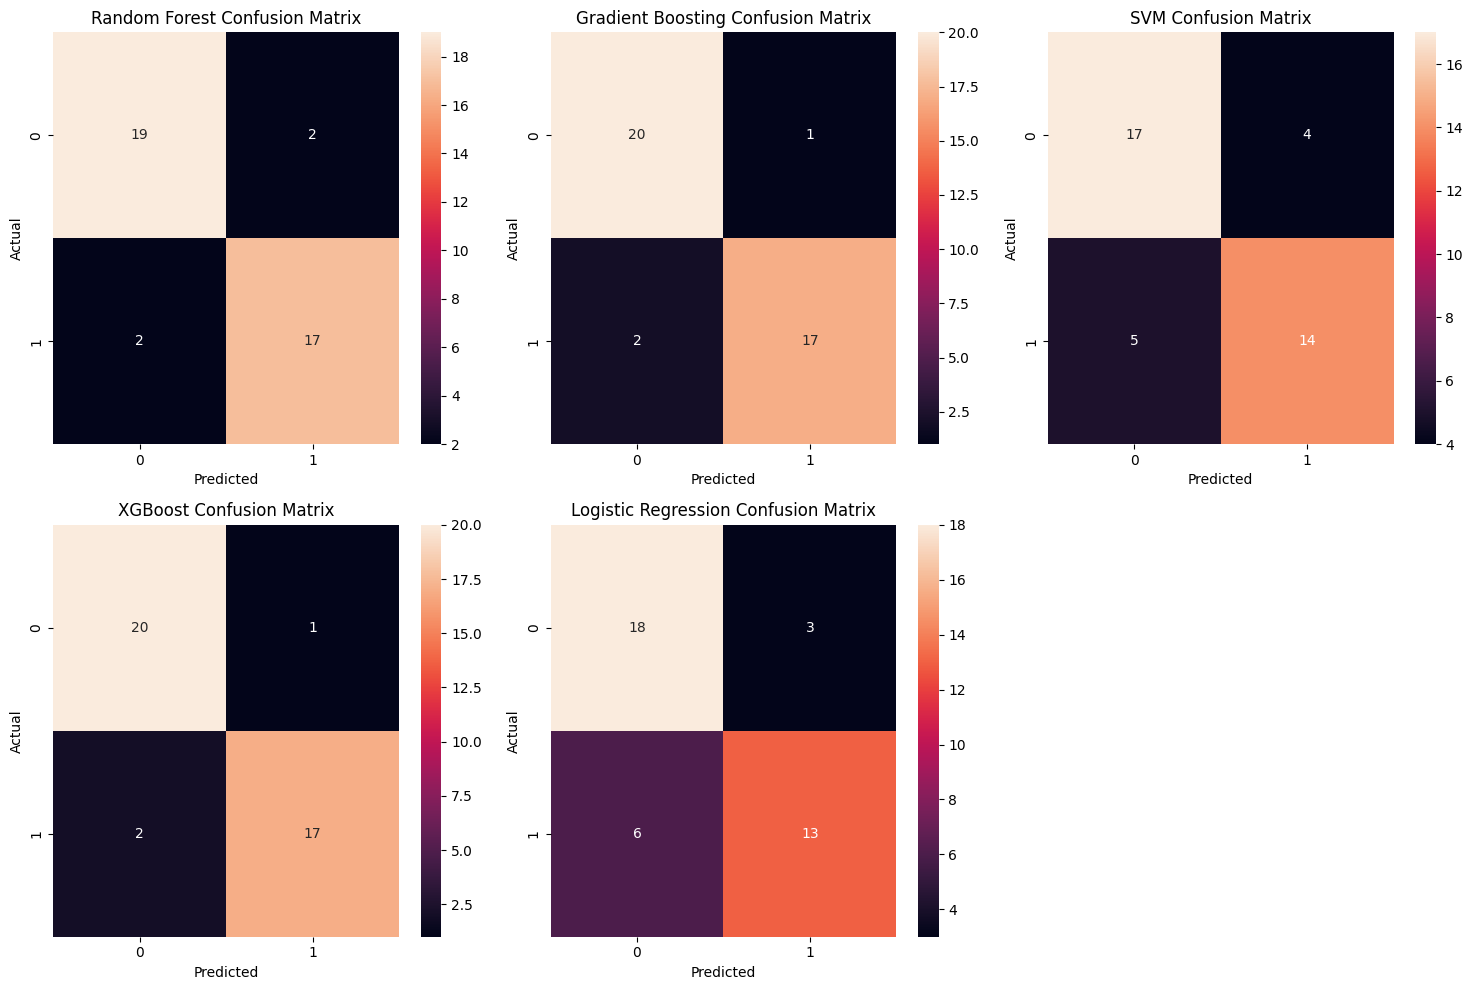

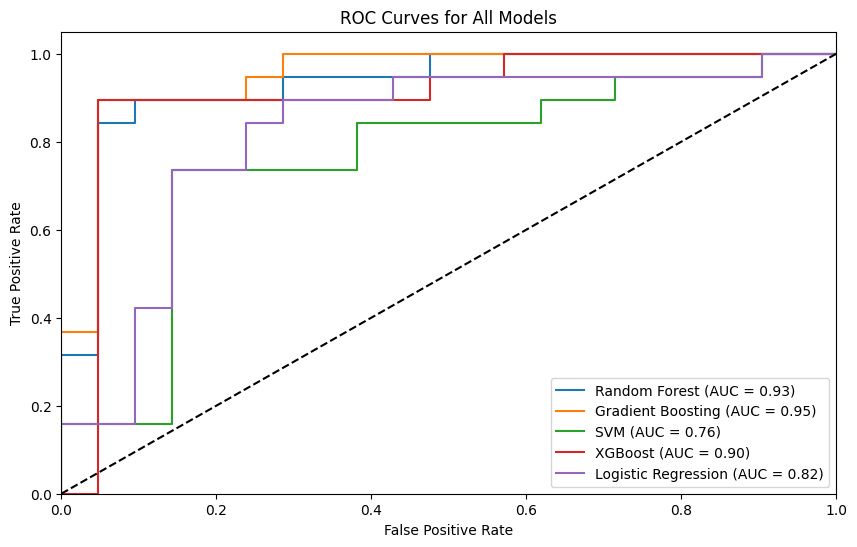

<Figure size 1200x600 with 0 Axes>

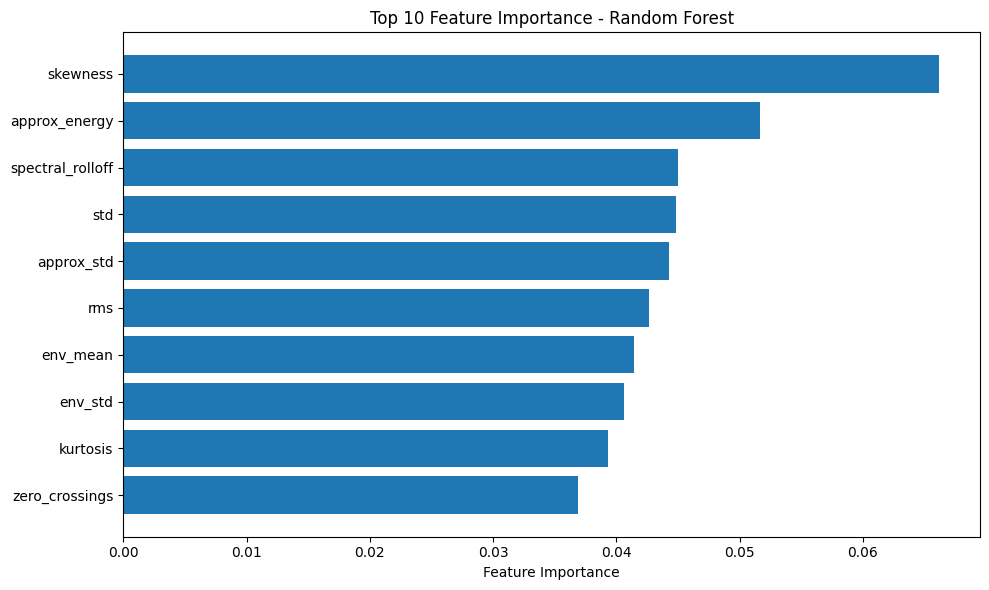

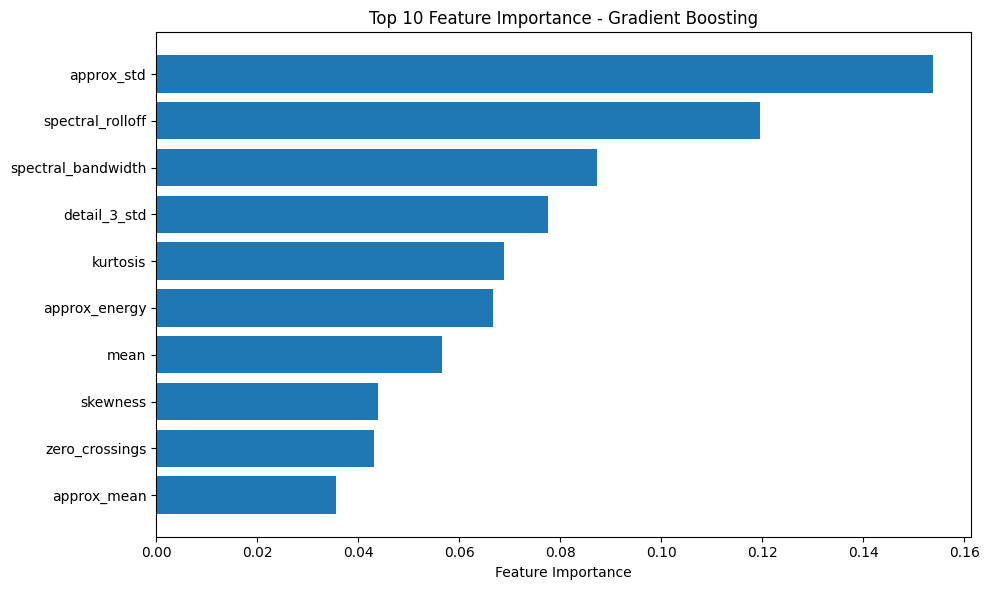

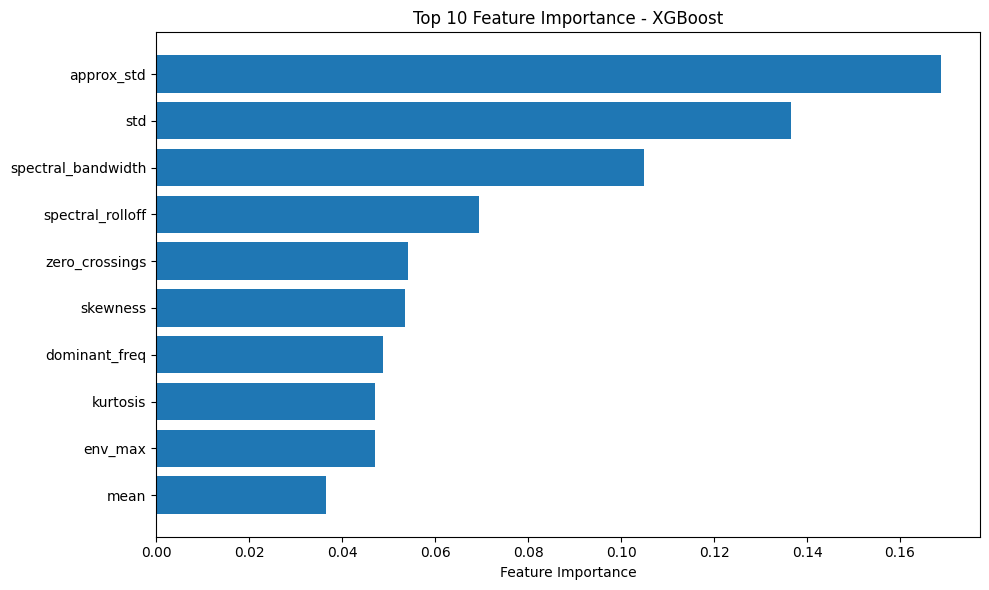

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Separate features and target
    X = df.drop('label', axis=1)
    y = df['label']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test, X.columns

def create_models():
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42)
    }
    
    # Define parameter grids for GridSearchCV
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear']
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        },
        'Logistic Regression': {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    }
    
    return models, param_grids

def evaluate_models(models, param_grids, X_train, X_test, y_train, y_test):
    results = {}
    best_models = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Create pipeline with scaling
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model)
        ])
        
        # Modify param_grid keys to match pipeline
        param_grid = {f'classifier__{k}': v for k, v in param_grids[name].items()}
        
        # Perform GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Get best model
        best_models[name] = grid_search.best_estimator_
        
        # Make predictions
        y_pred = grid_search.predict(X_test)
        
        # Calculate metrics
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'Best Parameters': grid_search.best_params_
        }
        
    return results, best_models

def plot_confusion_matrices(best_models, X_test, y_test):
    n_models = len(best_models)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(best_models.items()):
        if idx < len(axes):
            y_pred = model.predict(X_test)
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx])
            axes[idx].set_title(f'{name} Confusion Matrix')
            axes[idx].set_xlabel('Predicted')
            axes[idx].set_ylabel('Actual')
    
    # Remove empty subplots if any
    for idx in range(len(best_models), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(best_models, X_test, y_test):
    plt.figure(figsize=(10, 6))
    
    for name, model in best_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models')
    plt.legend(loc="lower right")
    plt.show()

def plot_feature_importance(best_models, feature_names):
    tree_based_models = {
        name: model for name, model in best_models.items() 
        if name in ['Random Forest', 'Gradient Boosting', 'XGBoost']
    }
    
    if tree_based_models:
        plt.figure(figsize=(12, 6))
        for name, model in tree_based_models.items():
            # Extract feature importance
            if name == 'XGBoost':
                importance = model.named_steps['classifier'].feature_importances_
            else:
                importance = model.named_steps['classifier'].feature_importances_
            
            # Sort features by importance
            indices = np.argsort(importance)[-10:]  
            plt.figure(figsize=(10, 6))
            plt.title(f'Top 10 Feature Importance - {name}')
            plt.barh(range(10), importance[indices])
            plt.yticks(range(10), feature_names[indices])
            plt.xlabel('Feature Importance')
            plt.tight_layout()
            plt.show()

def main():
    print("Loading and preprocessing data...")
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data('module-6-dataset.csv')
    
    print("\nCreating models...")
    models, param_grids = create_models()
    
    print("\nEvaluating models...")
    results, best_models = evaluate_models(models, param_grids, X_train, X_test, y_train, y_test)
    
    print("\nModel Performance Results:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        for metric, value in metrics.items():
            if metric != 'Best Parameters':
                print(f"{metric}: {value:.4f}")
        print("Best Parameters:", metrics['Best Parameters'])
    
    print("\nGenerating plots...")
    plot_confusion_matrices(best_models, X_test, y_test)
    plot_roc_curves(best_models, X_test, y_test)
    plot_feature_importance(best_models, feature_names)

if __name__ == "__main__":
    main()

Since Random Forest gave the best results, we will proceed with that model.